# Notebook for processing IMERG Rainfall data in Blob

This notebook is used to process the rainfall data on Blob for each cyclone since Favio. It extracts the daily on-land rainfall values from -2 days to +5 days to landfall in a 250km radius around the landfall location.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
from azure.storage.blob import ContainerClient
import numpy as np
import warnings
from shapely.geometry import Point
from rasterio.features import geometry_mask
from scipy.interpolate import interp1d
from pyproj import CRS
from src.constants import *
from src.utils import *
from src.datasources import rsmc, helpers

False

In [ ]:
load_dotenv()

dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

In [5]:
warnings.filterwarnings("ignore")

In [13]:
gdf_adm0 = codab.load_codab(admin_level=0)
gdf_adm1 = codab.load_codab(admin_level=1)
gdf_sel = gdf_adm1[
    gdf_adm1["ADM1_PT"].isin(constants.ADMS)
]  # [gdf_adm1.ADM1_PT.isin(constants.ADMS)]

# gdf_sel = gdf_adm1[~gdf_adm1["ADM1_PT"].str.startswith("Maputo")]
gdf_sel = gdf_sel.dissolve("ADM0_PT")
ibtracs_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "glb"
    / "ibtracs"
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

gdf_adm2 = codab.load_codab(admin_level=2)
gdf_sel_adm2 = gdf_adm2[gdf_adm2.ADM1_PT.isin(constants.ADMS)]

minx, miny, maxx, maxy = gdf_sel.total_bounds

In [10]:
# blob_names = existing_files = [
#    x.name for x in dev_glb_container_client.list_blobs(name_starts_with="imerg/v6/")
# ]

<Axes: >

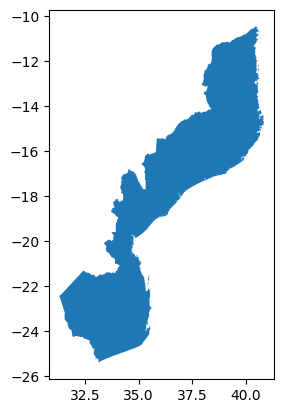

In [14]:
gdf_sel.plot()

In [11]:
gdf_ibtracs = gpd.read_file(ibtracs_path)

In [15]:
gdf_adm1_sel_buff = (
    gdf_adm0  # [gdf_adm1.ADM1_PT.isin(constants.ADMS)].buffer(250 / 111)
)
# also making sure to take one time step before landfall since some storms even off shore can cause a lot of rain
gdf_ibtracs_time = gdf_ibtracs[gdf_ibtracs["ISO_TIME"] >= "2000-01-01"]
# which cyclones made landfall or came close by around 50km to land
landfall_cyclones = gpd.sjoin(
    gdf_ibtracs_time, gdf_sel, how="inner", predicate="intersects"
)["NAME"].unique()

In [16]:
landfall_cyclones

array(['ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       'FAVIO', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA', 'HARUNA', 'DELIWE',
       'GUITO', 'HELLEN', 'CHEDZA', 'DINEO', 'DESMOND', 'IDAI', 'KENNETH',
       'CHALANE', 'ELOISE', 'GUAMBE', 'ANA', 'GOMBE', 'JASMINE', 'FREDDY',
       'FILIPO'], dtype=object)

In [17]:
PROD_BLOB_SAS = "sv=2023-11-03&st=2024-12-04T12%3A06%3A06Z&se=2024-12-05T12%3A06%3A06Z&skoid=76be2646-6e67-4317-8a2e-cdb622c93dd0&sktid=0f9e35db-544f-4f60-bdcc-5ea416e6dc70&skt=2024-12-04T12%3A06%3A06Z&ske=2024-12-05T12%3A06%3A06Z&sks=b&skv=2023-11-03&sr=c&sp=rl&sig=9fDlqm%2Bk3fryJQKDPEQ0Nc%2BP3uuAJMBjtf5K2MgE79U%3D"
PROD_BLOB_NAME = "imb0chd0prod"

In [18]:
combined_df = []
landfall_locs = []
# dates = pd.date_range(start="2003-03-11", periods=len(das), freq="D")
radii = list(range(50, 501, 50))
radii = [250]

In [19]:
for cyc in landfall_cyclones:
    cyc_df = gdf_ibtracs_time[gdf_ibtracs_time["NAME"] == cyc]
    # Convert ISO_TIME to datetime and set as index
    cyc_df["ISO_TIME"] = pd.to_datetime(cyc_df["ISO_TIME"])
    cyc_df.set_index("ISO_TIME", inplace=True)

    # Resample the DataFrame to the desired frequency
    cyc_df = cyc_df.resample("30T").asfreq()

    # Interpolate numerical columns and forward fill text columns
    for column in cyc_df.columns:
        if pd.api.types.is_numeric_dtype(cyc_df[column]):
            non_nan = cyc_df[column].dropna()
            if len(non_nan) > 1:
                interp_func = interp1d(
                    non_nan.index.astype(np.int64),
                    non_nan.values,
                    kind="linear",
                    fill_value="extrapolate",
                )
                cyc_df[column] = interp_func(cyc_df.index.astype(np.int64))
        else:
            cyc_df[column] = cyc_df[column].ffill()

    # Reset index
    cyc_df.reset_index(inplace=True)
    cyc_df["geometry"] = cyc_df.apply(
        lambda row: Point(row["LON"], row["LAT"]), axis=1
    )
    cyc_df = gpd.GeoDataFrame(cyc_df, geometry="geometry")
    cyc_df["date"] = pd.to_datetime(cyc_df["ISO_TIME"]).dt.date
    cyc_sjoin = gpd.sjoin(cyc_df, gdf_adm0, how="left", predicate="within")
    cyc_df["ADM0_PT"] = cyc_sjoin["ADM0_PT"]
    cyc_df["actual_within_land"] = cyc_sjoin["index_right"].notna()
    cyc_df["point_location"] = np.where(
        cyc_df["actual_within_land"], "Within", "Outside"
    )

    first_landfall = (
        cyc_df[cyc_df["actual_within_land"]].index[0]
        if not cyc_df[cyc_df["actual_within_land"]].empty
        else None
    )

    if first_landfall is not None:
        entry_times = []
        lookback = 4
        for i in range(lookback, len(cyc_df)):
            if (
                not cyc_df["actual_within_land"].iloc[i - 1]
                and cyc_df["actual_within_land"].iloc[i]
            ):
                direction_east_to_west = True
                for j in range(i - lookback, i - 1):
                    if cyc_df["LON"].iloc[j] < cyc_df["LON"].iloc[j + 1]:
                        direction_east_to_west = False
                        break
                if direction_east_to_west:
                    entry_times.append(cyc_df["ISO_TIME"].iloc[i])

        entry_times = pd.to_datetime(entry_times)
        entry_dates = pd.Series(entry_times).dt.date.unique().tolist()

        if len(entry_dates) == 1:
            entry_times = [entry_times[0]]

        cyc_df.loc[cyc_df["ISO_TIME"].isin(entry_times), "point_location"] = (
            "Landfall"
        )
        if cyc == "FREDDY":
            landfall_locs.append(
                cyc_df[cyc_df["point_location"] == "Landfall"].iloc[0]
            )
        else:
            landfall_locs.append(
                cyc_df[cyc_df["point_location"] == "Landfall"]
            )
        print(cyc)
        for landfall in entry_times:
            landfall_time = pd.to_datetime(
                cyc_df[cyc_df["point_location"] == "Landfall"][
                    "ISO_TIME"
                ].values[0]
            )
            lf_dt = cyc_df[cyc_df["point_location"] == "Landfall"]

            # Iterate over each date and radius
            storm_df_list = []
            for time_step in range(-1, 2):
                date = landfall + pd.Timedelta(days=time_step)
                target_date = date.normalize()
                blob_name = f"imerg/v7/late/processed/imerg-daily-late-{target_date.strftime('%Y-%m-%d')}.tif"
                cog_url = f"https://{PROD_BLOB_NAME}.blob.core.windows.net/raster/{blob_name}?{PROD_BLOB_SAS}"

                try:
                    da_in = rxr.open_rasterio(cog_url, masked=True)
                    da_in = da_in.persist()
                    if da_in.rio.crs is None:
                        da_in.rio.write_crs("EPSG:4326", inplace=True)
                except Exception as e:
                    da_in = None

                if da_in is not None:
                    for radius in radii:
                        # Create a GeoDataFrame for the landfall point with the buffer
                        gdf_lf = gpd.GeoDataFrame(
                            {
                                "geometry": [
                                    Point(
                                        lf_dt["LON"].values[0],
                                        lf_dt["LAT"].values[0],
                                    ),
                                ]
                            },
                            crs=CRS("EPSG:4326"),
                        )

                        # Reprojecting the GeoDataFrame to a local CRS for Mozambique (South Africa Albers)
                        gdf_lf = gdf_lf.to_crs("EPSG:21037")

                        # Create buffer in meters
                        gdf_lf["geometry"] = gdf_lf.buffer(
                            radius * 1000
                        )  # Buffer radius in meters
                        gdf_lf = gdf_lf.to_crs(
                            "EPSG:4326"
                        )  # Reproject back to EPSG:4326

                        # Perform spatial intersection with the provinces (gdf_sel)
                        gdf_lf_intersection = gpd.overlay(
                            gdf_lf, gdf_sel, how="intersection"
                        )

                        # Initialize a list to store the results
                        storm_df_list = []

                        if (
                            gdf_lf_intersection.shape[0] > 0
                        ):  # Check if there's any intersection
                            # Iterate through each province in the clipped GeoDataFrame (gdf_lf_intersection)
                            for (
                                idx,
                                province,
                            ) in gdf_lf_intersection.iterrows():
                                # Extract the geometry of the province
                                province_geom = province.geometry

                                # Create a mask based on the province geometry
                                mask = geometry_mask(
                                    [province_geom],
                                    transform=da_in.rio.transform(),
                                    invert=True,  # Mask the areas outside the province
                                    out_shape=da_in.rio.shape,
                                )

                                # Apply the mask to the raster (da_in is the raster data)
                                masked_da = da_in.where(mask)

                                # Extract the values of the masked raster (non-NaN values)
                                values = masked_da.values[
                                    ~np.isnan(masked_da.values)
                                ]

                                # Compute the median value for the province
                                median_value = (
                                    np.median(values)
                                    if values.size > 0
                                    else np.nan
                                )

                                # Append the results to the list
                                storm_df_list.append(
                                    {
                                        "storm": cyc,  # Storm name/identifier
                                        "date": date,  # Date of the event
                                        "time_step": time_step,  # Time step of the data
                                        "radius": radius,  # Radius of the buffer
                                        "province": province[
                                            "ADM1_PT"
                                        ],  # Province name
                                        "median_precip": median_value,  # Median precipitation value
                                    }
                                )

                        else:
                            # If no intersection, append NaN values for the provinces
                            print(f"No intersection for {cyc} - {time_step}")
                            storm_df_list.append(
                                {
                                    "storm": cyc,
                                    "date": date,
                                    "time_step": time_step,
                                    "radius": radius,
                                    "province": None,
                                    "median_precip": np.nan,
                                }
                            )

                # Create DataFrame from storm_df_list
                storm_df = pd.DataFrame(storm_df_list)
                combined_df.append(storm_df)

ASTRIDE
ELINE:LEONE
GLORIA
HUDAH
DELFINA
JAPHET
FAVIO
JOKWE
IZILDA
DANDO
IRINA
HARUNA
DELIWE
GUITO
HELLEN
CHEDZA
DINEO
DESMOND
IDAI
KENNETH
CHALANE
ELOISE
GUAMBE
ANA
GOMBE
JASMINE
FREDDY
FILIPO


In [20]:
# Combine all DataFrames into a single DataFrame
rain_df = pd.concat(combined_df, ignore_index=True)
landfall_df = pd.concat(landfall_locs, ignore_index=True)

In [21]:
rain_df

""


In [256]:
rain_df = rain_df.drop_duplicates(subset=["storm", "time_step", "province"])

In [257]:
rain_df.to_csv(
    Path(constants.AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "daily_imerg_cyclone_landfall_fixed_adm_sel_v7.csv"
)
landfall_df.to_csv(
    Path(constants.AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed_adm_sel_v7.csv"
)

In [258]:
rain_df[rain_df["storm"] == "FREDDY"].drop_duplicates(
    subset=["storm", "time_step", "province"]
)

,storm,date,time_step,radius,province,median_precip
222,FREDDY,2023-03-10 17:30:00,-1,250,Nampula,70.942505
223,FREDDY,2023-03-10 17:30:00,-1,250,Sofala,2.535000
224,FREDDY,2023-03-10 17:30:00,-1,250,Tete,4.325000
225,FREDDY,2023-03-10 17:30:00,-1,250,Zambezia,24.175001
226,FREDDY,2023-03-11 17:30:00,0,250,Nampula,70.292503
227,FREDDY,2023-03-11 17:30:00,0,250,Sofala,32.100002
228,FREDDY,2023-03-11 17:30:00,0,250,Tete,55.800003
229,FREDDY,2023-03-11 17:30:00,0,250,Zambezia,55.825005
230,FREDDY,2023-03-12 17:30:00,1,250,Nampula,25.184998
231,FREDDY,2023-03-12 17:30:00,1,250,Sofala,51.650002
